In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
import pprint

In [191]:
# Read files
first_user_df = pd.read_csv("first_user_data.csv")
second_user_df = pd.read_csv("second_user_data.csv")
first_user_info_df = pd.read_csv("first_user_info.csv")
second_user_info_df = pd.read_csv("second_user_info.csv")

In [192]:
print(len(first_user_df))
print(len(second_user_df))

1282
109


In [193]:
# Drop duplicate records
first_user_df.drop_duplicates(subset = ["id"], keep = "first", inplace = True)
second_user_df.drop_duplicates(subset = ["id"], keep = "first", inplace = True)

In [194]:
print(len(first_user_df))
print(len(second_user_df))

1111
107


In [195]:
first_user_df.head()

,id,song,artist,album,popularity,duration,img_url,genres
0,2C0sdXFRzSeVERbPYwRocB,目及皆是你 - 心跳版,小蓝背心,目及皆是你,49,175000,https://i.scdn.co/image/ab67616d0000b273cf2696...,['chinese viral pop']
1,2yQSlIvIfRD8pVcNbDhXNw,還是會想你,林達浪,還是會想你,51,190063,https://i.scdn.co/image/ab67616d0000b2734ccb1f...,['chinese viral pop']
2,3xCHPowgMf0ZgXPxXHhUFX,I Love You - 伴奏,汪東城,I Love You (中文版),7,182567,https://i.scdn.co/image/ab67616d0000b2736aec71...,[]
3,08Lw339w7ziPVRVq6B57fo,I Love You - 中文版,汪東城,I Love You (中文版),34,182567,https://i.scdn.co/image/ab67616d0000b2736aec71...,[]
4,4X5SAZ4JKejo2tPhvCJhZf,愛的魔法,金莎,他不愛我,43,191895,https://i.scdn.co/image/ab67616d0000b273d3a256...,"['mainland chinese pop', 'mandopop']"


In [196]:
second_user_df.head()

,id,song,artist,album,popularity,duration,img_url,genres
0,4fpEuKIzTLmMJnYwFU0oqr,Death with Dignity,Sufjan Stevens,Carrie & Lowell,50,239508,https://i.scdn.co/image/ab67616d0000b2734dfbe3...,"['baroque pop', 'chamber pop', 'freak folk', '..."
1,4tcwdkKzXn0Tsyz3WtH3gc,In My Mind (feat. Brian Viglione),Amanda Palmer,Goes Down Under,0,253506,https://i.scdn.co/image/ab67616d0000b2738c7753...,"['anti-folk', 'dark cabaret', 'piano rock', 's..."
2,7yC7FWZz24L43brXzNpLWT,To All of You,Syd Matters,Someday We Will Foresee Obstacles,55,283266,https://i.scdn.co/image/ab67616d0000b273baf75f...,"['folktronica', 'french indie folk']"
3,3jfZ9M23l0L7RxzYMTgBTv,Looking Out for You,Joy Again,Looking Out for You,79,179499,https://i.scdn.co/image/ab67616d0000b2735448a3...,"['indie garage rock', 'indie pop']"
4,24HPkbkXJsIFC4eyg63zgQ,Wraith Pinned to the Mist and Other Games,of Montreal,The Sunlandic Twins,57,255613,https://i.scdn.co/image/ab67616d0000b27338a6cc...,"['alternative dance', 'alternative rock', 'ant..."


In [197]:
first_user_df["artist"].value_counts()

first_user_df["popularity"].value_counts()


0     150
49     31
74     25
41     24
43     24
     ... 
84      2
87      1
11      1
15      1
93      1
Name: popularity, Length: 89, dtype: int64

In [198]:
first_user_df.sort_values(by=["popularity"])

,id,song,artist,album,popularity,duration,img_url,genres
612,7e92ANVU4mGFFG3buPSBns,너도 나처럼 I Wonder If You Hurt Like Me,2AM,F.Scott Fitzgerald's Way Of Love,0,228453,https://i.scdn.co/image/ab67616d0000b2734ee17c...,"['k-pop', 'korean pop']"
576,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,0,201933,https://i.scdn.co/image/ab67616d0000b273216499...,"['acoustic pop', 'neo mellow', 'pop rock', 'vi..."
568,1nlKYpqe2qT1fwiXMr6ju3,Give Love,AKMU,PLAY,0,176532,https://i.scdn.co/image/ab67616d0000b2731b9293...,"['k-pop', 'korean pop']"
567,3jM4UiYD4GLhlbDzGRVkkX,200%,AKMU,PLAY,0,193321,https://i.scdn.co/image/ab67616d0000b2731b9293...,"['k-pop', 'korean pop']"
564,4awRNvd5iC7QGVQOwSCffw,Wings,Little Mix,DNA (Deluxe),0,219733,https://i.scdn.co/image/ab67616d0000b27358b8c3...,"['dance pop', 'girl group', 'pop', 'post-teen ..."
...,...,...,...,...,...,...,...,...
963,0ct6r3EGTcMLPtrXHDvVjc,The Nights,Avicii,The Days / Nights,85,176658,https://i.scdn.co/image/ab67616d0000b2730ae4f4...,"['dance pop', 'edm', 'pop', 'pop dance']"
119,0u2P5u6lvoDfwTYjAADbn4,lovely (with Khalid),Billie Eilish,lovely (with Khalid),86,200185,https://i.scdn.co/image/ab67616d0000b2738a3f0a...,"['electropop', 'pop']"
58,0pqnGHJpmpxLKifKRmU6WP,Believer,Imagine Dragons,Evolve,86,204346,https://i.scdn.co/image/ab67616d0000b2735675e8...,"['modern rock', 'pop', 'rock']"
1244,2CVChktEKBsM6v4IfdFU5k,double take,dhruv,double take,87,171743,https://i.scdn.co/image/ab67616d0000b2737eab04...,"['chill r&b', 'nyc pop']"


In [199]:
def generateDictionary(dataframe, column):
    user_data = []
    if column not in dataframe:
        print("Column doesn't exist")
        return 0
    
    for row in dataframe[column]:
        row_data = row.replace("[","").replace("]","").replace("'","").split(", ")
        if row_data:
            user_data += row_data

    user_data = [i for i in user_data if i]

    user_dict = dict()

    for row in user_data:
        user_dict[row] = user_dict.get(row,0) + 1
    
    return user_dict

In [200]:
def plot(genres_dictionary, user_dataframe, feature):
    user_genres_dict = genres_dictionary
    username = user_dataframe["display_name"][0]
    def take(n, iterable):
        return dict(islice(iterable, n))

    sorted_user_genres =  {k: v for k, v in sorted(user_genres_dict.items(), 
                                                             reverse = True, key=lambda item: item[1])}
    top_10_user_genres = take(10, sorted_user_genres.items())

    plt.barh(list(top_10_user_genres.keys()), top_10_user_genres.values() , align='center')
    plt.xlabel("Counts")
    plt.ylabel(feature.capitalize())
    plt.title(username + "'s top " + feature)
    plt.show()

In [201]:
first_user_genres_dict = generateDictionary(first_user_df, "genres")
second_user_genres_dict = generateDictionary(second_user_df, "genres")

first_user_artists_dict = generateDictionary(first_user_df, "artist")
second_user_artists_dict = generateDictionary(second_user_df, "artist")

first_user_songs_dict = generateDictionary(first_user_df, "id")
second_user_songs_dict = generateDictionary(second_user_df, "id")

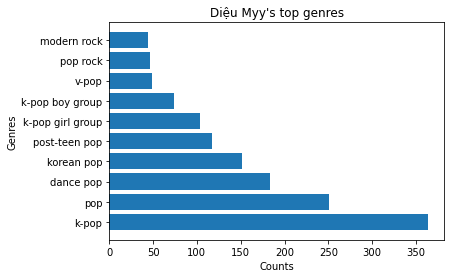

In [202]:
plot(first_user_genres_dict, first_user_info_df, "genres")

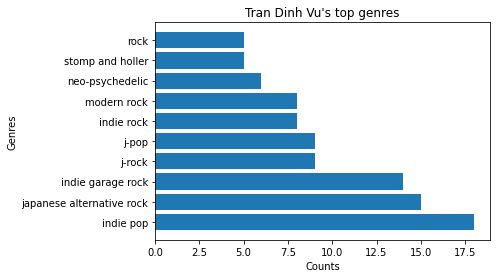

In [203]:
plot(second_user_genres_dict, second_user_info_df, "genres")

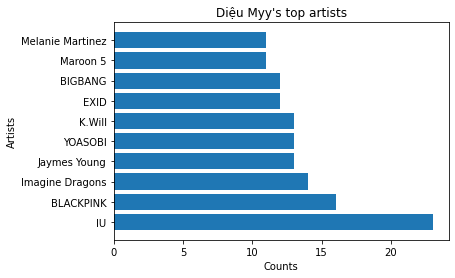

In [204]:
plot(first_user_artists_dict, first_user_info_df, "artists")

C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12493 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from c

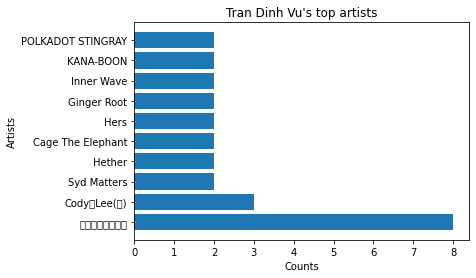

In [205]:
plot(second_user_artists_dict, second_user_info_df, "artists")

In [206]:
def featureAnalysis(first_user_dict, second_user_dict, feature):
    first_user_feature = first_user_dict
    second_user_feature = second_user_dict
    
    common_features = dict()
    for key in first_user_feature:
        if key in second_user_feature:
            common_features[key] = min(first_user_feature[key], second_user_feature[key])
    
    if common_features:
        sorted_common_features =  {k: v for k, v in sorted(common_features.items(), 
                                                             reverse = True, key=lambda item: item[1])}
    
        print("Most common " + feature + ":")
        for i,key in enumerate(sorted_common_features):
            if i == 5: break
            if feature == "songs":
                song = first_user_df.loc[first_user_df["id"]==key].values[0]
                print(song[1] + " by " + song[2] + " in " + song[3])
            else:
                print(key, sorted_common_features[key])
    else:
        print("No common " + feature)
        
#     score = len(set(first_) & set(test_list2)) / float(len(set(test_list1) | set(test_list2))) * 100

In [207]:
featureAnalysis(first_user_genres_dict, second_user_genres_dict, "genres")

Most common genres:
j-pop 9
modern rock 8
j-rock 6
rock 5
indie pop 3


In [208]:
featureAnalysis(first_user_artists_dict, second_user_artists_dict, "artists")

Most common artists:
ZUTOMAYO 1
KANA-BOON 1


In [209]:
featureAnalysis(first_user_songs_dict, second_user_songs_dict, "songs")


Most common songs:
シルエット by KANA-BOON in Time


In [210]:
def popularityAnalysis(first_dataframe, first_user_info_df, second_dataframe, second_user_info_df):
    print(first_user_info_df["display_name"][0] + "'s average songs' popularity is", first_dataframe["popularity"].mean())
    print(second_user_info_df["display_name"][0] + "'s average songs' popularity is", second_dataframe["popularity"].mean())
    print("\n")
    
    max_first_pop = first_dataframe.sort_values(by=["popularity"]).iloc[-1]
    min_first_pop = first_dataframe.sort_values(by=["popularity"]).iloc[0]
    
   
    
    print(first_user_info_df["display_name"][0] + "'s most and least popular songs are")                                                
    print(max_first_pop["song"] + " by " + max_first_pop["artist"] + " with popularity " + str(max_first_pop["popularity"]))
    print(min_first_pop["song"] + " by " + min_first_pop["artist"] + " with popularity " + str(min_first_pop["popularity"]))
    print("\n")
    max_second_pop = second_dataframe.sort_values(by=["popularity"]).iloc[-1]
    min_second_pop = second_dataframe.sort_values(by=["popularity"]).iloc[0]
    
    print(second_user_info_df["display_name"][0] + "'s most and least popular songs are")
    print(max_second_pop["song"] + " by " + max_second_pop["artist"] + " with popularity " + str(max_second_pop["popularity"]))
    print(min_second_pop["song"] + " by " + min_second_pop["artist"] + " with popularity " + str(min_second_pop["popularity"]))

In [211]:
popularityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df)

Diệu Myy's average songs' popularity is 42.76237623762376
Tran Dinh Vu's average songs' popularity is 38.953271028037385


Diệu Myy's most and least popular songs are
STAY (with Justin Bieber) by The Kid LAROI with popularity 93
너도 나처럼 I Wonder If You Hurt Like Me by 2AM with popularity 0


Tran Dinh Vu's most and least popular songs are
Looking Out for You by Joy Again with popularity 79
In My Mind (feat. Brian Viglione) by Amanda Palmer with popularity 0
